In [4]:
# database

import sqlite3
import redis
from redis.exceptions import ConnectionError
from enum import Enum
import pandas as pd


class RsKey(Enum):
    MAP = "chart_map"
    LINE = "chart_line"
    BAR = "chart_bar"
    PIE = "chart_pie"
    LIQUID = "chart_liquid"
    # Python接口
    PRE_USER = "pre_user_data"  # 预处理用户数据
    PRE_ROUTE = "pre_route_data"  # 预处理路线数据
    PRE_ORDER = "pre_order_data"  # 预处理订单数据
    # SpringBoot接口
    BASE_PANEL = "base_panel"  # 基础面板数据
    BIG_SCREEN = "big-screen-data"  # 大屏数据


class SqliteOpt:
    def __init__(self, path: str):
        self._conn = sqlite3.connect(path)
        self._cursor = self._conn.cursor()

    def __del__(self):
        self._cursor.close()
        self._conn.close()

    def execute(self, sql: str):
        self._cursor.execute(sql)
        return self._cursor

    def fetchall(self, tb: str, fields: list = ["*"], condition: str = "") -> list:
        fds = ",".join(fields)
        if condition:
            condition = f" WHERE {condition}"
        self.execute(f"SELECT {fds} FROM {tb}{condition}")
        return self._cursor.fetchall()

    def fetchcount(self, tb: str, condition: str = "") -> int:
        if condition:
            condition = f" WHERE {condition}"
        self.execute(f"SELECT COUNT(*) FROM {tb}{condition}")
        return self._cursor.fetchone()[0]

    def fetchone(self, tb: str, fields: list = ["*"], condition: str = ""):
        fds = ",".join(fields)
        if condition:
            condition = f" WHERE {condition}"
        self.execute(f"SELECT {fds} FROM {tb}{condition}")
        return self._cursor.fetchone()
    
    def read_to_pandas(self, tb: str) -> pd.DataFrame:
        return pd.read_sql(f"SELECT * FROM {tb}", self._conn)
    
    def read_to_pandas_by_sql(self, sql: str) -> pd.DataFrame:
        return pd.read_sql(sql, self._conn)


class RedisOpt:
    def __init__(self, host: str, port: int, db: int, password: str = None):
        self._r = redis.Redis(host=host, port=port, db=db, password=password)
        try:
            if self._r.ping():
                print("Redis OPT 连接成功...")
            else:
                print("Redis OPT 连接失败...")
        except ConnectionError:
            print("Redis OPT 连接失败...")

    def __del__(self):
        self._r.close()
        print("Redis OPT 连接关闭...")

    def _set(self, key: str, value: str):
        self._r.set(key, value)

    def get(self, key: str):
        return self._r.get(key).decode()

    def set_base_panel(self, value: str):
        self._set(RsKey.BASE_PANEL.value, value)

    def set_big_screen(self, value: str):
        self._set(RsKey.BIG_SCREEN.value, value)

    def save_pre_data(self, key: RsKey, value: str):
        self._set(key.value, value)

    def read(self, key: RsKey) -> str:
        return self.get(key.value)
    
    def read_pandas(self, key: RsKey) -> pd.DataFrame:
        return pd.read_json(self.get(key.value))


sqlite = SqliteOpt("../../db.sqlite3")
# rds = RedisOpt("127.0.0.1", 6379, 0)

In [5]:
# sqlite user data
# 读取sqlite中的user数据
user_data = sqlite.read_to_pandas("user_user")
# 对数据进行处理，去除列：id、password、last_login、avatar、idnum
user_data = user_data.drop(columns=["id", "password", "last_login", "avatar", "idnum", "username"])
# 处理数据：删除wid和phone为空的行
user_data = user_data.dropna(subset=["wid", "phone"])
# 处理异常值：删除wid不为数字和字母的行以及phone不为1开头的11位数字的行,删除superuser的行
user_data = user_data[user_data["wid"].str.isalnum()]
user_data = user_data[user_data["phone"].str.match(r"^1\d{10}$")]
user_data = user_data[user_data["is_superuser"] == False]

user_data.head()
# 将数据写入redis
# rds.save_pre_data(RsKey.PRE_USER, user_data.to_json(orient="records", force_ascii=False))

,is_superuser,phone,wid,gender,is_staff
3,0,13893223523,20200226086,1,1
4,0,18893470713,20191109003,0,1
5,0,13639311109,20191108086,1,1
6,0,13739318381,20191108087,1,1
7,0,18298402237,20191108089,0,1


In [9]:
# sqlite route data
# 读取sqlite中的route数据
route_sql = """
select
    ri.rdate,
    ri.rtime,
    rst.rname,
    rst.rtype,
    si.seat as seat_list,
    ci.cnum,
    ci.cseat
from
    route_info ri
left join
    route_station rst on ri.route_station_id = rst.id
left join
    seat_info si on ri.id = si.route_id
left join
    car_info ci on ri.car_id = ci.id;
"""

route_data = sqlite.read_to_pandas_by_sql(route_sql)
# 删除rname最后一个字符
route_data["rname"] = route_data["rname"].str[:-1]
# seat字段中的值为[6, 13]字符串或None，将其转为列表，然后新建字段存储长度
route_data["seat_list"] = route_data["seat_list"].apply(lambda x: eval(x) if x else [])
route_data["used_seat"] = route_data["seat_list"].apply(lambda x: len(x))
# 排序字段
route_data = route_data[['rdate', 'rtime', 'rname', 'rtype', 'cnum', 'cseat', 'used_seat', 'seat_list']]

route_data
# 将数据写入redis
# rds.save_pre_data(RsKey.PRE_ROUTE, route_data.to_json(orient="records", force_ascii=False))

,rdate,rtime,rname,rtype,cnum,cseat,used_seat,seat_list
0,2023-09-05,1,A,1,甘A09322D,47,1,[4]
1,2023-09-05,1,B,1,甘A16705D,47,0,[]
2,2023-09-05,1,C,1,甘A06238D,47,0,[]
3,2023-09-05,1,D,1,甘A11206D,47,0,[]
4,2023-09-05,1,E,1,甘A16369D,47,0,[]
...,...,...,...,...,...,...,...,...
1854,2024-03-02,1,周末,1,甘A06238D,47,0,[]
1855,2024-03-09,0,周末,0,甘A06238D,47,2,"[6, 13]"
1856,2024-03-09,1,周末,1,甘A06238D,47,1,[1]
1857,2024-03-16,0,周末,0,甘A06238D,47,2,"[1, 13]"


In [10]:
# sqlite order data

order_sql = """
select
    od.number,
    od.status,
    od.station,
    od.seat,
    od.created,
    od.updated,
    ri.rdate,
    ri.rtime,
    rst.rname
from
    orders od
join
    route_info ri on od.route_id = ri.id
join
    route_station rst on ri.route_station_id = rst.id;
"""

order_data = sqlite.read_to_pandas_by_sql(order_sql)

# 其中station的字段为 `南关十字(7:00)`，需要将其拆分为两个字段：station_name和station_time
order_station = order_data["station"].str.extract(r"(.+)\((\d{1,2}:\d{2})\)")
order_data["station_name"] = order_station[0]
order_data["station_time"] = order_station[1]
# 删除字段rname中的最后一个字符
order_data["rname"] = order_data["rname"].str[:-1]

# 删除字段station，并将字段重新排序
order_data = order_data.drop(columns=["station"])
order_data = order_data[["number", "status", "station_name", "station_time", "seat", "created", "updated", "rdate", "rtime", "rname"]]

order_data
# 将数据写入redis
# rds.save_pre_data(RsKey.PRE_ORDER, order_data.to_json(orient="records", force_ascii=False))

,number,status,station_name,station_time,seat,created,updated,rdate,rtime,rname
0,16946000000347551112,3,天水路北口,17:50,1,2023-09-13 18:13:20.034755,2023-09-13 18:13:20.034755,2023-09-15,1,E
1,169460000822232510141,3,南关十字,7:00,10,2023-09-13 18:13:28.222325,2023-09-13 18:13:28.222325,2023-09-14,0,E
2,1694600037472676799,3,二十二嘉园,18:08,7,2023-09-13 18:13:57.472676,2023-09-13 18:13:57.472676,2023-09-14,1,B
3,169460005116020718123,3,二十二嘉园,6:52,18,2023-09-13 18:14:11.160207,2023-09-13 18:14:11.160207,2023-09-14,0,B
4,16946000744729171099,3,理工大后家属院,18:10,10,2023-09-13 18:14:34.472917,2023-09-13 18:14:34.472917,2023-09-14,1,B
...,...,...,...,...,...,...,...,...,...,...
3512,171031080053827872364,1,学校,16:35,7,2024-03-13 14:20:00.538278,2024-03-13 14:20:00.538278,2024-03-13,1,E
3513,17103152004793282190,1,学校,16:35,8,2024-03-13 15:33:20.494851,2024-03-13 15:33:20.494851,2024-03-13,1,B
3514,1710479156035813132369,1,旋路,7:22,13,2024-03-15 13:05:56.035813,2024-03-15 13:05:56.035813,2024-03-16,0,周末
3515,171048012332141612369,1,交通大学,6:38,1,2024-03-15 13:22:03.321416,2024-03-15 13:22:03.321416,2024-03-16,0,周末


Exception ignored in: <function SqliteOpt.__del__ at 0x0000018F54A52020>
Traceback (most recent call last):
  File "D:\UpdateFile\Temp\ipykernel_22096\1152934462.py", line 31, in __del__
AttributeError: 'SqliteOpt' object has no attribute '_cursor'


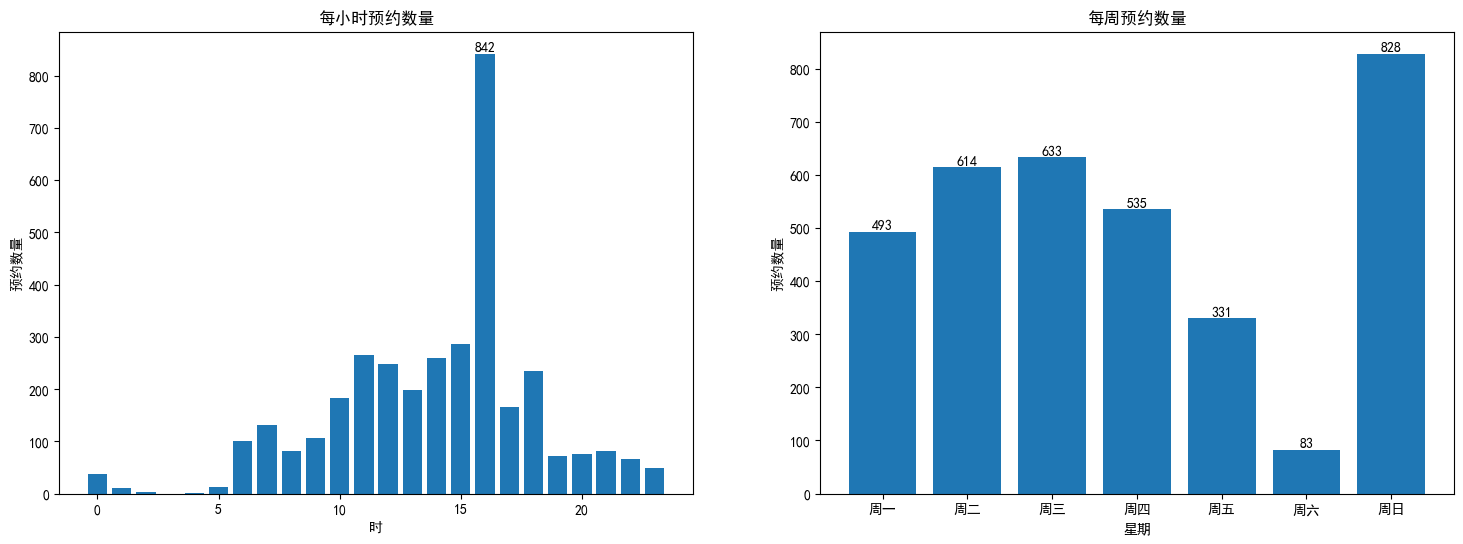

'\n通过分析结果可以看出：\n每天的预约数量在上午10点到下午4点之间较多，其中下午2点到4点达到最高点，预约数量达到842次，这说明大部分用户在下午2点到4点之间进行预约，而校车的发车时间大多在下午4点到6点之间，这样可以保证用户在下班后有足够的时间进行预约。\n每周的预约数量在周一到周五以及周日之间较多，其中周日达到峰值828次，周六的预约数量较少，这说明大部分用户在工作日和周末有较多的时间进行预约，而周六的预约数量较少，可能是因为周六是休息日，用户不需要使用校车。\n'

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置中文显示
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

# 将'created'列转换为datetime格式
order_data["created"] = pd.to_datetime(order_data["created"])
# 创建一个新列'hour'，表示小时
order_data["hour"] = order_data["created"].dt.hour
# 对'hour'列进行分组，计算每个小时的预约数量
hourly_orders = order_data.groupby("hour").size()
# 创建一个新列'day_of_week'，表示星期几
order_data["day_of_week"] = order_data["created"].dt.dayofweek
# 对'day_of_week'列进行分组，计算每个星期几的预约数量
weekly_orders = order_data.groupby("day_of_week").size()


# 创建画布，绘制2个子图
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# 绘制第一个子图
ax[0].bar(hourly_orders.index, hourly_orders.values)
ax[0].set_title("每小时预约数量")
ax[0].set_xlabel("时")
ax[0].set_ylabel("预约数量")
# 最高点显示数值
max_value = max(hourly_orders.values)
max_index = list(hourly_orders).index(max_value)
ax[0].text(max_index + 1, max_value, max_value, ha="center", va="bottom")

# 绘制第二个子图
ax[1].bar(weekly_orders.index, weekly_orders.values)
ax[1].set_title("每周预约数量")
ax[1].set_xlabel("星期")
ax[1].set_ylabel("预约数量")
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(["周一", "周二", "周三", "周四", "周五", "周六", "周日"])
for i, v in enumerate(weekly_orders.values):
    ax[1].text(i, v, v, ha="center", va="bottom")

plt.show()

"""
通过分析结果可以看出：
每天的预约数量在上午10点到下午4点之间较多，其中下午2点到4点达到最高点，预约数量达到842次，这说明大部分用户在下午2点到4点之间进行预约，而校车的发车时间大多在下午4点到6点之间，这样可以保证用户在下班后有足够的时间进行预约。
每周的预约数量在周一到周五以及周日之间较多，其中周日达到峰值828次，周六的预约数量较少，这说明大部分用户在工作日和周末有较多的时间进行预约，而周六的预约数量较少，可能是因为周六是休息日，用户不需要使用校车。
"""

In [11]:
# 查询order_data中有哪些station_name
# order_data["station_name"].unique()

longitude_and_latitude = {
    "天水路北口": [103.870745, 36.07734],
    "南关十字": [103.832267,36.061207],
    "二十二嘉园": [103.78698,36.063002],
    "理工大后家属院": [103.785809,36.065084],
    "广场西口": [103.844979,36.060069],
    "杨家桥": [103.758399,36.059711],
    "公园路口": [103.637171,36.09668],
    "Q5公交站": [103.707723,36.064911],
    "学校": [103.762653,36.564132],
    "海关": [103.716345,36.100344],
    "西关什字": [103.823213,36.064768],
    "盘旋路": [103.860888,36.056185],
    "黄金大厦": [103.777846,36.073756],
    "富润家园": [103.74435,36.055243],
    "龚一小对面": [103.750659,36.058734],
    "建工局": [103.789412,36.071994],
    "寺儿沟": [103.617935,36.10352],
    "中铁21局": [103.690671,36.108046],
    "瑞岭雅苑北门": [103.6965,36.490827],
    "元通桥": [103.832021,36.072326],
    "瑞岭国际酒店": [103.67773,36.489847],
    "新黄河市场": [103.774382,36.086738],
    "西湖公园": [103.8059,36.068987],
    "大砂坪小学": [103.840883,36.083125],
    "培黎广场": [103.751489,36.105106],
    "民乐路东口": [103.767221,36.063099],
    "中海河山郡": [103.677153,36.119464],
    "恒大翡翠华庭": [103.722877,36.06945],
    "龚一小": [103.750659,36.058734],
    "天银宾馆": [103.796728,36.067508],
    "深安桥南": [103.684215,36.096712],
    "大砂坪小学公交站": [103.84075,36.082158],
    "甘农厂": [103.769616,36.064054],
    "交通大学": [103.731761,36.111419],
    "刘家堡": [103.700328,36.113079],
    "旋路": [102.864176,36.348526],
}

# 将经纬度添加到order_data中，不存在的站点删除这一行
order_data = order_data.dropna(subset=["station_name"])
order_data["longitude"] = order_data["station_name"].map(lambda x: longitude_and_latitude.get(x)[0])
order_data["latitude"] = order_data["station_name"].map(lambda x: longitude_and_latitude.get(x)[1])


D:\UpdateFile\Temp\ipykernel_22096\378275147.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_data["longitude"] = order_data["station_name"].map(lambda x: longitude_and_latitude.get(x)[0])
D:\UpdateFile\Temp\ipykernel_22096\378275147.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_data["latitude"] = order_data["station_name"].map(lambda x: longitude_and_latitude.get(x)[1])


In [14]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# 创建一个GeoDataFrame
geometry = [Point(xy) for xy in zip(order_data["longitude"], order_data["latitude"])]
gdf = gpd.GeoDataFrame(order_data, geometry=geometry)

# 删除不需熬的列：number, status, seat, created, updated, rdate, rtime, rname, hour, day_of_week
gdf = gdf.drop(columns=["number", "status", "seat"])

gdf

,station_name,station_time,created,updated,rdate,rtime,rname,longitude,latitude,geometry
0,天水路北口,17:50,2023-09-13 18:13:20.034755,2023-09-13 18:13:20.034755,2023-09-15,1,E,103.870745,36.077340,POINT (103.87074 36.07734)
1,南关十字,7:00,2023-09-13 18:13:28.222325,2023-09-13 18:13:28.222325,2023-09-14,0,E,103.832267,36.061207,POINT (103.83227 36.06121)
2,二十二嘉园,18:08,2023-09-13 18:13:57.472676,2023-09-13 18:13:57.472676,2023-09-14,1,B,103.786980,36.063002,POINT (103.78698 36.06300)
3,二十二嘉园,6:52,2023-09-13 18:14:11.160207,2023-09-13 18:14:11.160207,2023-09-14,0,B,103.786980,36.063002,POINT (103.78698 36.06300)
4,理工大后家属院,18:10,2023-09-13 18:14:34.472917,2023-09-13 18:14:34.472917,2023-09-14,1,B,103.785809,36.065084,POINT (103.78581 36.06508)
...,...,...,...,...,...,...,...,...,...,...
3512,学校,16:35,2024-03-13 14:20:00.538278,2024-03-13 14:20:00.538278,2024-03-13,1,E,103.762653,36.564132,POINT (103.76265 36.56413)
3513,学校,16:35,2024-03-13 15:33:20.494851,2024-03-13 15:33:20.494851,2024-03-13,1,B,103.762653,36.564132,POINT (103.76265 36.56413)
3514,旋路,7:22,2024-03-15 13:05:56.035813,2024-03-15 13:05:56.035813,2024-03-16,0,周末,102.864176,36.348526,POINT (102.86418 36.34853)
3515,交通大学,6:38,2024-03-15 13:22:03.321416,2024-03-15 13:22:03.321416,2024-03-16,0,周末,103.731761,36.111419,POINT (103.73176 36.11142)


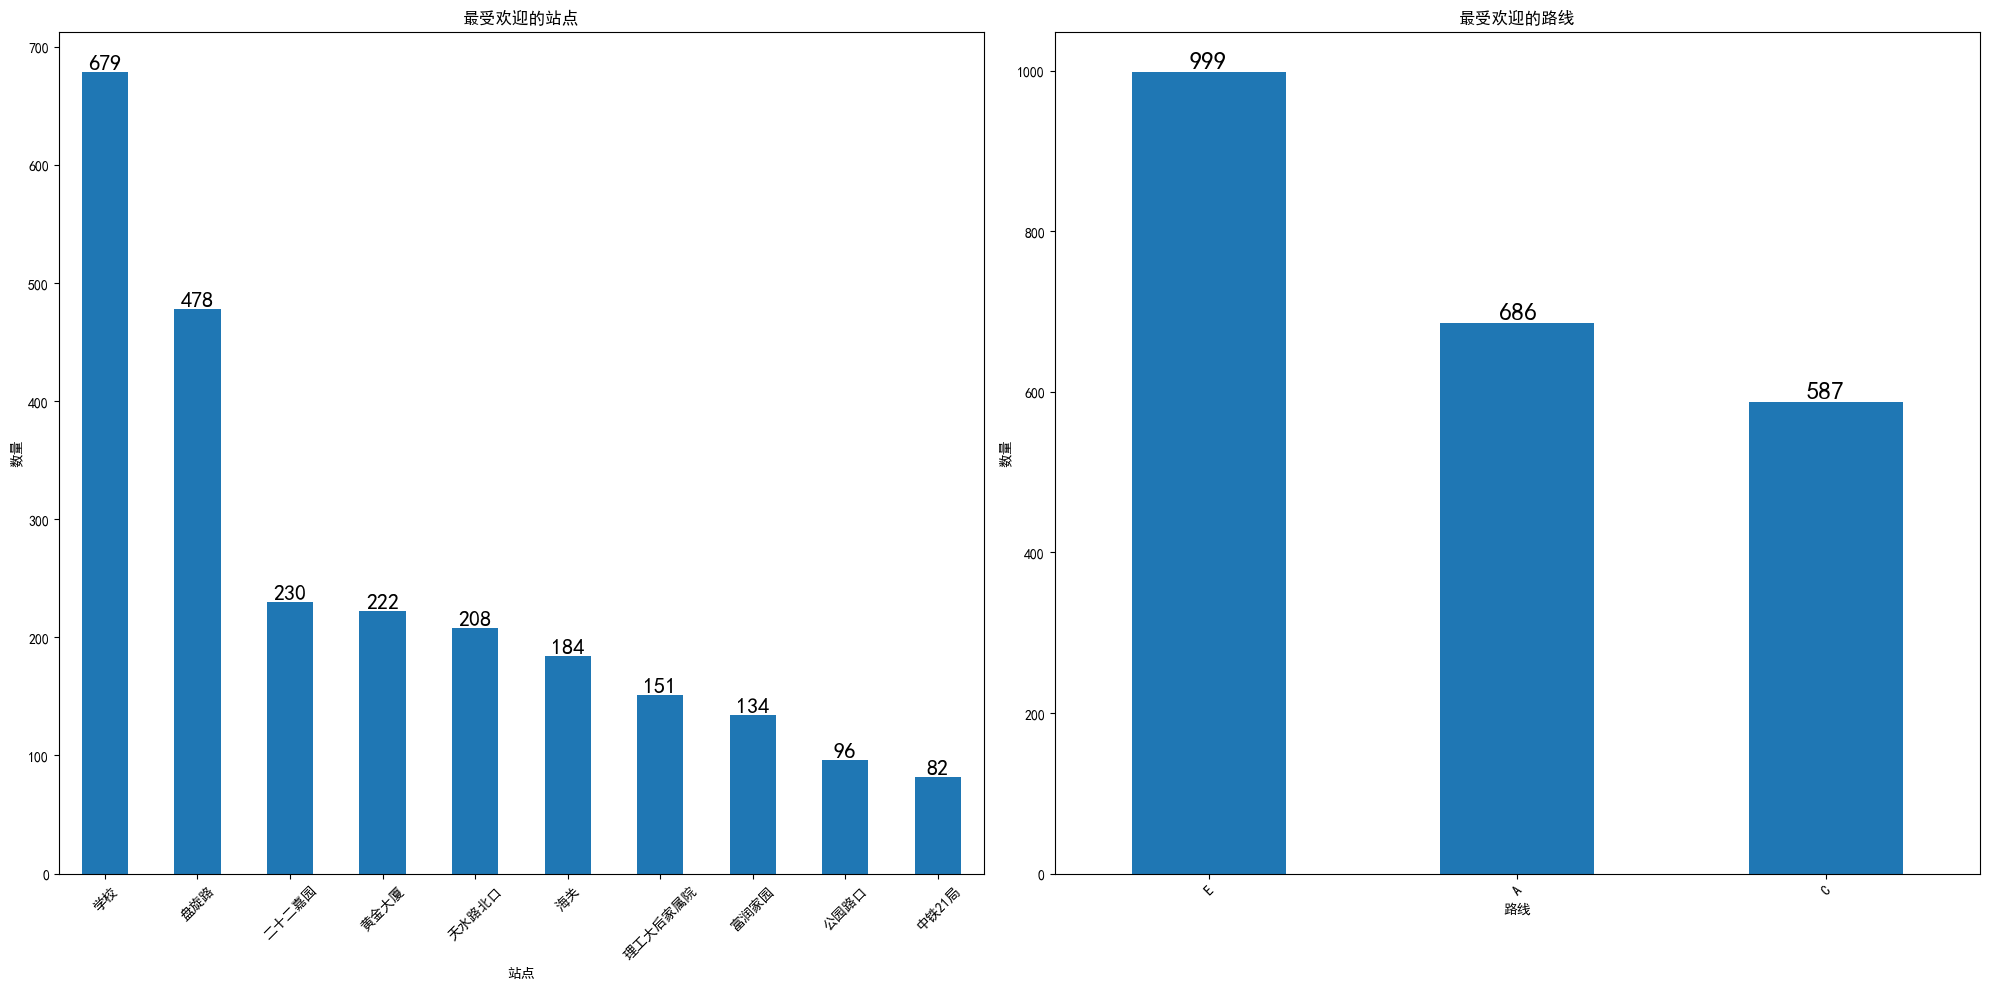

In [8]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# 创建一个GeoDataFrame
geometry = [Point(xy) for xy in zip(order_data["longitude"], order_data["latitude"])]
gdf = gpd.GeoDataFrame(order_data, geometry=geometry)

# 分析数据
popular_station = gdf['station_name'].value_counts().head(10)
popular_route = gdf['rname'].value_counts().head(3)

# 创建画布，绘制2个子图
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

popular_station.plot(kind='bar', ax=ax[0])
ax[0].set_title("最受欢迎的站点")
ax[0].set_xlabel("站点")
ax[0].set_ylabel("数量")
ax[0].tick_params(axis='x', labelrotation=45)


popular_route.plot(kind='bar', ax=ax[1])
ax[1].set_title("最受欢迎的路线")
ax[1].set_xlabel("路线")
ax[1].set_ylabel("数量")
ax[1].tick_params(axis='x', labelrotation=45)
for i, v in enumerate(popular_station.values):
    ax[0].text(i, v, v, ha="center", va="bottom", fontsize=16)
for i, v in enumerate(popular_route.values):
    ax[1].text(i, v, v, ha="center", va="bottom", fontsize=18)

plt.tight_layout()

plt.show()


   total_seat  total_used  occupancy_rate
0       87373        3420        0.039143


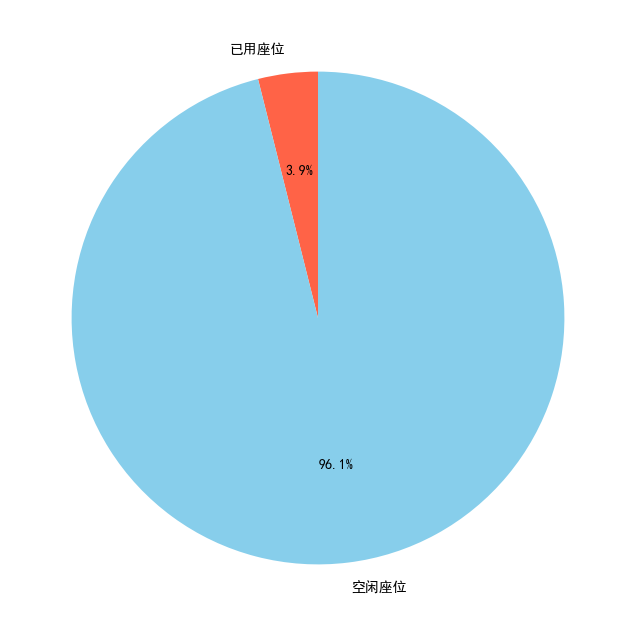

In [10]:
# route_data

# 将route_data中cseat相加，used_seat相加,形成新的DataFrame，只有两个字段total_seat和total_used
# total_seat = route_data.groupby("rname")["cseat"].sum()
# total_used = route_data.groupby("rname")["used_seat"].sum()
# total_data = pd.concat([total_seat, total_used], axis=1)
# total_data.columns = ["total_seat", "total_used"]
# total_data = total_data.reset_index()

# total_data

# 计算出总的座位数和已用座位数，形成一个新的DataFrame
total_seat = route_data["cseat"].sum()
total_used = route_data["used_seat"].sum()
total_data = pd.DataFrame({"total_seat": [total_seat], "total_used": [total_used]})

# 计算上座率
total_data["occupancy_rate"] = total_data["total_used"] / total_data["total_seat"]
print(total_data)


plt.figure(figsize=(8, 8))
labes = ["已用座位", "空闲座位"]
colors = ["#FF6347", "#87CEEB"]
data = [total_data["total_used"].values[0], total_data["total_seat"].values[0] - total_data["total_used"].values[0]]
plt.pie(data, labels=labes, autopct="%1.1f%%", startangle=90, colors=colors)
plt.show()

    rname  total_seat  total_used  occupancy_rate
8       E       15275         986        0.064550
9   E线（假期        2068         132        0.063830
1   A线（假期        2068         109        0.052708
0       A       15275         654        0.042815
5   C线（假期        2068          85        0.041103
4       C       15275         565        0.036989
2       B       15275         544        0.035614
3   B线（假期        2068          71        0.034333
10     周末         658          17        0.025836
7   D线（假期        2068          37        0.017892
6       D       15275         220        0.014403


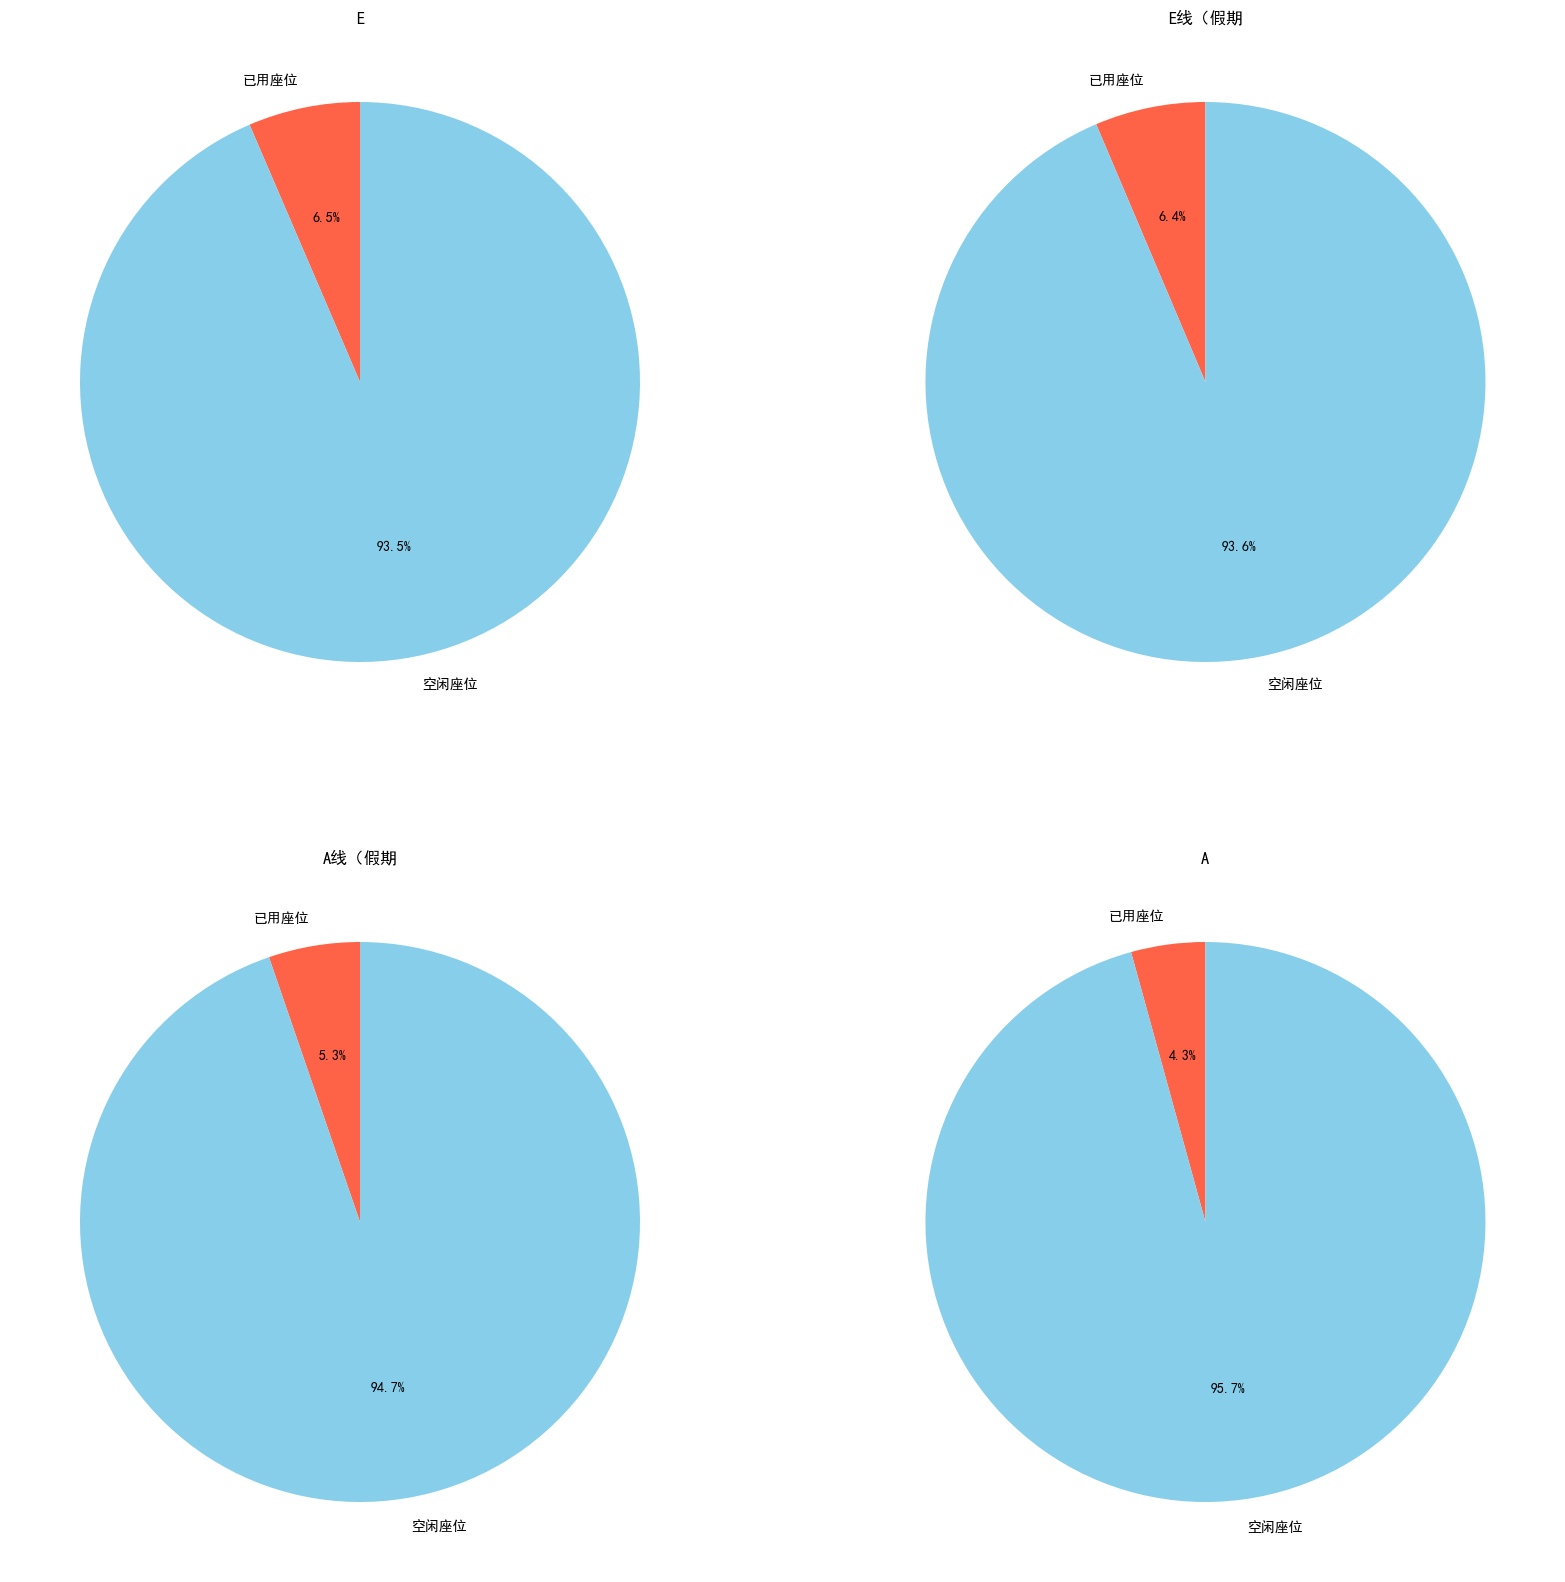

In [15]:
# 将route_data中cseat相加，used_seat相加,形成新的DataFrame，只有两个字段total_seat和total_used
total_seat = route_data.groupby("rname")["cseat"].sum()
total_used = route_data.groupby("rname")["used_seat"].sum()
total_data = pd.concat([total_seat, total_used], axis=1)
total_data.columns = ["total_seat", "total_used"]
total_data = total_data.reset_index()

# total_data

# 计算上座率，按上座率降序排列
total_data["occupancy_rate"] = total_data["total_used"] / total_data["total_seat"]
total_data = total_data.sort_values("occupancy_rate", ascending=False)
print(total_data)

# 绘制前四个饼图
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for i in range(4):
    data = [total_data["total_used"].values[i], total_data["total_seat"].values[i] - total_data["total_used"].values[i]]
    ax[i // 2][i % 2].pie(data, labels=labes, autopct="%1.1f%%", startangle=90, colors=colors)
    ax[i // 2][i % 2].set_title(total_data["rname"].values[i])
plt.show()
